<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/12_midlevel_data_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 10.7 MB/s 
     |████████████████████████████████| 362 kB 39.3 MB/s 
     |████████████████████████████████| 4.4 MB 34.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.0 MB/s 
     |████████████████████████████████| 212 kB 44.0 MB/s 
     |████████████████████████████████| 140 kB 44.5 MB/s 
     |████████████████████████████████| 1.1 MB 19.8 MB/s 
     |████████████████████████████████| 101 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 30.2 MB/s 
     |████████████████████████████████| 127 kB 44.8 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 54.5 MB/s 
     |████████████████████████████████| 144 kB 51.2 MB/s 
     |████████████████████████████████| 6.6 MB 39.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

In [3]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [4]:
from fastai.text.all import *
from fastai.vision.all import *


# Data Munging with fastai's Mid-Level API

We have seen what `Tokenizer` and `Numericalize` do to a collection of texts, and how they're used inside the data block API, which handles those transforms for us directly using the `TextBlock`. But what if we want to only apply one of those transforms, either to see intermediate results or because we have already tokenized texts? More generally, what can we do when the data block API is not flexible enough to accommodate our particular use case? For this, we need to use fastai's *mid-level API* for processing data. The data block API is built on top of that layer, so it will allow you to do everything the data block API does, and much much more.

## Going Deeper into fastai's Layered API

The fastai library is built on a *layered API*. In the very top layer 
there are *applications* that allow us to train a model in five lines of 
codes, as we saw. In the case of creating `DataLoaders` for a text classifier, for instance, we used the line:

In [5]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

The factory method `TextDataLoaders.from_folder` is very convenient when your data is arranged the exact same way as the IMDb dataset, but in practice, that often won't be the case. The data block API offers more flexibility. 

In [6]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But it's sometimes not flexible enough. For debugging purposes, for instance, we might need to apply just parts of the transforms that come with this data block. Or we might want to create a `DataLoaders` for some application that isn't directly supported by fastai. In this section, we'll dig into the pieces that are used inside fastai to implement the data block API. Understanding these will enable you to leverage the power and flexibility of this mid-tier API.

> note: Mid-Level API: The mid-level API does not only contain functionality for creating `DataLoaders`

### Transforms

When we studied tokenization and numericalization in the last chapter, we started by grabbing a bunch of texts:

In [7]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

We then showed how to tokenize them with a `Tokenizer`:

In [8]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0][:10]

(#10) ['xxbos','i','got','this','as','a','turkey','movie','and','was']

and how to numericalize, including automatically creating the vocab for our corpus:

In [9]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,   18,  195,   20,   31,   12, 1560,   27,   13,   24])

The classes also have a `decode` method. For instance, `Numericalize.decode` gives us back the string tokens:

In [10]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','i','got','this','as','a','turkey','movie','and','was']

and `Tokenizer.decode` turns this back into a single string (it may not, however, be exactly the same as the original string; this depends on whether the tokenizer is *reversible*:

In [11]:
tok.decode(nums_dec)

'xxbos i got this as a turkey movie and was'

`decode` is used by fastai's `show_batch` and `show_results`, as well as some other inference methods, to convert predictions and mini-batches into a human-understandable representation.

For each of `tok` or `num` in the preceding example, we created an object, called the `setup` method (which trains the tokenizer if needed for `tok` and creates the vocab for `num`), applied it to our raw texts (by calling the object as a function), and then finally decoded the result back to an understandable representation. These steps are needed for most data preprocessing tasks, so fastai provides a class that encapsulates them. This is the `Transform` class. Both `Tokenize` and `Numericalize` are `Transform`s.

In general, a `Transform` is an object that behaves like a function and has an optional `setup` method that will initialize some inner state (like the vocab inside `num`) and an optional `decode` that will reverse the function (this reversal may not be perfect, as we saw with `tok`).

A good example of `decode` is found in the `Normalize` transform that we saw in chapter_sizing_and_tta: to be able to plot the images its `decode` method undoes the normalization (i.e., it multiplies by the standard deviation and adds back the mean). On the other hand, data augmentation transforms do not have a `decode` method, since we want to show the effects on images to make sure the data augmentation is working as we want.

A special behavior of `Transform`s is that they always get applied over tuples. In general, our data is always a tuple `(input,target)` (sometimes with more than one input or more than one target). When applying a transform on an item like this, such as `Resize`, we don't want to resize the tuple as a whole; instead, we want to resize the input (if applicable) and the target (if applicable) separately. It's the same for batch transforms that do data augmentation: when the input is an image and the target is a segmentation mask, the transform needs to be applied (the same way) to the input and the target.

We can see this behavior if we pass a tuple of texts to `tok`:

In [12]:
tok((txts[0], txts[1]))

((#231) ['xxbos','i','got','this','as','a','turkey','movie','and','was'...],
 (#207) ['xxbos','xxmaj','while','i','have','never','been','a','fan','of'...])

### Writing Your Own Transform

If you want to write a custom transform to apply to your data, the easiest way is to write a function. As you can see in this example, a `Transform` will only be applied to a matching type, if a type is provided (otherwise it will always be applied). In the following code, the `:int` in the function signature means that `f` only gets applied to `int`s. That's why `tfm(2.0)` returns `2.0`, but `tfm(2)` returns `3` here:

In [13]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

Here, `f` is converted to a `Transform` with no `setup` and no `decode` method.

Python has a special syntax for passing a function (like `f`) to another function (or something that behaves like a function, known as a *callable* in Python), called a *decorator*. A decorator is used by prepending a callable with `@` and placing it before a function definition (there are lots of good online tutorials about Python decorators, so take a look at one if this is a new concept for you). The following is identical to the previous code:

In [14]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

If you need either `setup` or `decode`, you will need to subclass `Transform` to implement the actual encoding behavior in `encodes`, then (optionally), the setup behavior in `setups` and the decoding behavior in `decodes`:

In [15]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

Here, `NormalizeMean` will initialize some state during the setup (the mean of all elements passed), then the transformation is to subtract that mean. For decoding purposes, we implement the reverse of that transformation by adding the mean. Here is an example of `NormalizeMean` in action:

In [16]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

Note that the method called and the method implemented are different, for each of these methods:

```asciidoc
[options="header"]
|======
| Class | To call | To implement
| `nn.Module` (PyTorch) | `()` (i.e., call as function) | `forward`
| `Transform` | `()` | `encodes`
| `Transform` | `decode()` | `decodes`
| `Transform` | `setup()` | `setups`
|======
```

So, for instance, you would never call `setups` directly, but instead would call `setup`. The reason for this is that `setup` does some work before and after calling `setups` for you. 

### Pipeline

To compose several transforms together, fastai provides the `Pipeline` class. We define a `Pipeline` by passing it a list of `Transform`s; it will then compose the transforms inside it. When you call `Pipeline` on an object, it will automatically call the transforms inside, in order:

In [18]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,   18,  195,   20,   31,   12, 1560,   27,   13,   24,   18,   34,  605,   10,   26,    8,  117,   25,  562,   72])

And you can call `decode` on the result of your encoding, to get back something you can display and analyze:

In [23]:
tfms.decode(t)[:100]

'xxbos i got this as a turkey movie and was i not disappointed . \n\n xxmaj acting - overall even thoug'

The only part that doesn't work the same way as in `Transform` is the setup. To properly set up a `Pipeline` of `Transform`s on some data, you need to use a `TfmdLists`.

## TfmdLists and Datasets: Transformed Collections

Your data is usually a set of raw items (like filenames, or rows in a DataFrame) to which you want to apply a succession of transformations. We just saw that a succession of transformations is represented by a `Pipeline` in fastai. The class that groups together this `Pipeline` with your raw items is called `TfmdLists`.

### TfmdLists

Here is the short way of doing the transformation we saw in the previous section:

In [24]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

At initialization, the `TfmdLists` will automatically call the `setup` method of each `Transform` in order, providing them not with the raw items but the items transformed by all the previous `Transform`s in order. We can get the result of our `Pipeline` on any raw element just by indexing into the `TfmdLists`:

In [25]:
t = tls[0]; t[:20]

TensorText([   2,   19,  208,   20,   27,   13, 2373,   30,   12,   25,   19,   38,  693,   10,   26,    8,  138,   24,  466,   78])

And the `TfmdLists` knows how to decode for show purposes:

In [29]:
tls.decode(t)[:100]

'xxbos i got this as a turkey movie and was i not disappointed . \n\n xxmaj acting - overall even thoug'

In fact, it even has a `show` method:

In [30]:
tls.show(t)

xxbos i got this as a turkey movie and was i not disappointed . 

 xxmaj acting - overall even though many have been in other movies it is clear that they had to work hard to act this bad so constantly over this entire movie with out accidentally letting slip some degree of acting . 

 xxmaj plot - being generous i could say that the scriptwriter did originally start with a plot but but did his best to ignore it . the plot broke down faster then a xxmaj chinese knock off computer 

 xxmaj scrip - now that was an abomination of nature . it failed to flow with any rhyme or reason . the majority of the lines by the characters were at best pathetic to imbecilic . the script worked hard to make sure that no character managed to get to be considered memorable . i have watched other movies where the extras were more interesting and memorable . 

 xxmaj special effects - xxup rotflmao xxrep 5 ! xxmaj they were short bus special 

 xxmaj directing - until you can come up with your own directing

The `TfmdLists` is named with an "s" because it can handle a training and a validation set with a `splits` argument. You just need to pass the indices of which elements are in the training set, and which are in the validation set:

In [31]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

You can then access them through the `train` and `valid` attributes:

In [32]:
tls.valid[0][:20]

TensorText([   2,    8,   53,  111,  101,   11,   19,   25,  910,   18,   22,   70,   22, 4240,  108,   14,    9,    8, 3038,    8])

If you have manually written a `Transform` that performs all of your preprocessing at once, turning raw items into a tuple with inputs and targets, then `TfmdLists` is the class you need. You can directly convert it to a `DataLoaders` object with the `dataloaders` method. This is what we will do in our Siamese example later in this chapter.

In general, though, you will have two (or more) parallel pipelines of transforms: one for processing your raw items into inputs and one to process your raw items into targets. For instance, here, the pipeline we defined only processes the raw text into inputs. If we want to do text classification, we also have to process the labels into targets. 

For this we need to do two things. First we take the label name from the parent folder. There is a function, `parent_label`, for this:

In [33]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

Then we need a `Transform` that will grab the unique items and build a vocab with them during setup, then transform the string labels into integers when called. fastai provides this for us; it's called `Categorize`:

In [34]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

To do the whole setup automatically on our list of files, we can create a `TfmdLists` as before:

In [35]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

But then we end up with two separate objects for our inputs and targets, which is not what we want. This is where `Datasets` comes to the rescue.

### Datasets

`Datasets` will apply two (or more) pipelines in parallel to the same raw object and build a tuple with the result. Like `TfmdLists`, it will automatically do the setup for us, and when we index into a `Datasets`, it will return us a tuple with the results of each pipeline:

In [36]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([   2,   19,  208,   20,   27,   13, 2373,   30,   12,   25,   19,   38,  693,   10,   26,    8,  138,   24,  466,   78]),
 TensorCategory(0))

Like a `TfmdLists`, we can pass along `splits` to a `Datasets` to split our data between training and validation sets:

In [37]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([   2,    8,   53,  111,  101,   11,   19,   25,  910,   18,   22,   70,   22, 4240,  108,   14,    9,    8, 3038,    8]),
 TensorCategory(1))

It can also decode any processed tuple or show it directly:

In [38]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos xxmaj like most people , i was interested in " more " solely because of the xxmaj pink xxmaj floyd soundtrack , which has turned out to be the only xxmaj pink xxmaj floyd album that i still listen to after all these years . xxmaj it was quite a surprise to run across the film in a local video store , in a digitally remastered version . xxmaj it was an even bigger surprise to find that it is a pretty good movie . \n\n xxmaj visually it is quite beautiful , especially when the two main characters are cavorting on the rocks on the xxmaj spanish island of xxmaj ibiza . xxmaj and the use of the soundtrack music , which as far as i can tell is exclusively by xxmaj pink xxmaj floyd , is excellent . xxmaj it was a joy to watch the film with my copy of the album alongside me , mentally ticking off each track as it was used in the film . xxmaj dave xxmaj xxunk \'s brief " a xxmaj spanish xxmaj piece " was the only one i did n\'t hear , and several tracks are used quite prominently , espe

The last step is to convert our `Datasets` object to a `DataLoaders`, which can be done with the `dataloaders` method. Here we need to pass along a special argument to take care of the padding problem (as we saw in [nlp post](https://alanfortunysicart.blogspot.com/2022/07/fastai-deep-learning-journey-part-11.html)). This needs to happen just before we batch the elements, so we pass it to `before_batch`: 

In [40]:
??pad_input

In [41]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

`dataloaders` directly calls `DataLoader` on each subset of our `Datasets`. fastai's `DataLoader` expands the PyTorch class of the same name and is responsible for collating the items from our datasets into batches. It has a lot of points of customization, but the most important ones that you should know are:

- `after_item`:: Applied on each item after grabbing it inside the dataset. This is the equivalent of `item_tfms` in `DataBlock`.
- `before_batch`:: Applied on the list of items before they are collated. This is the ideal place to pad items to the same size.
- `after_batch`:: Applied on the batch as a whole after its construction. This is the equivalent of `batch_tfms` in `DataBlock`.

As a conclusion, here is the full code necessary to prepare the data for text classification:

In [42]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

The two differences from the previous code are the use of `GrandparentSplitter` to split our training and validation data, and the `dl_type` argument. This is to tell `dataloaders` to use the `SortedDL` class of `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

This does the exact same thing as our previous `DataBlock`:

In [44]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But now, you know how to customize every single piece of it!

Let's practice what we just learned about this mid-level API for data preprocessing, using a computer vision example now.

## Applying the Mid-Level Data API: SiamesePair to detect beluga whales to perform conservation efforts

I the following, we will use the data set from the following competition containing images from around 800 beluga whales from the top in order to correctly track them to perform conservation efforts.[ beluga whales challenge](https://www.drivendata.org/competitions/96/beluga-whales/). As we have around 7 images per whale it is a good case for a siamese network, which can be implemented using the mid level data api.

A *Siamese model* takes two images and has to determine if they are of the same class or not. 

First things first, let's get the images in our dataset:

In [ ]:
# get the images file unzipped
#!unzip '/content/gdrive/MyDrive/MidLevelAPI/images.zip' -d '/content/gdrive/MyDrive/MidLevelAPI'

In [45]:
#load metadata
csv_file_path = '/content/gdrive/MyDrive/MidLevelAPI/metadata (1).csv'
data_import= pd.read_csv(csv_file_path)   

In [46]:
# change the path to make the renaming easier of the files according to a desired regex pattern whaleid_id.jpg
data_import['path'] = data_import['path'].str.replace('images/','')

In [ ]:
# the following code is used once to filter only top views (90% of the views in the data) and to rename the images according to the pattern above
# ONLY RUN ONCE!

#collection =  '/content/gdrive/MyDrive/MidLevelAPI/images'
#i=0
#for images in os.listdir(collection):
#  # remove photos that are not from the top, as they are < 10%
#  if ((data_import.loc[data_import['path'] == images,'viewpoint'] == 'right') | (data_import.loc[data_import['path'] == images,'viewpoint'] == 'left')).all():
#    filename = data_import.loc[data_import['path'] == images,'image_id'][i] + "."+ 'jpg'
#    path = os.path.join(collection, filename)
#    os.remove(path)
#  # rename name as whale id _ unique identifier plus jpg
#  else: 
#    newname = (data_import.loc[data_import['path'] == images,'whale_id'] + "_"+ str(i) + '.jpg').to_string()
#    os.rename(collection +'/'+images, collection+'/'+newname)
#  i=i+1  

In [47]:
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/MidLevelAPI/images')

In [48]:
path.ls()

(#5434) [Path('/content/gdrive/MyDrive/MidLevelAPI/images/4817    whale062_4817.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4818    whale169_4818.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4819    whale326_4819.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4820    whale008_4820.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4821    whale107_4821.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4822    whale169_4822.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4823    whale197_4823.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4824    whale062_4824.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4825    whale713_4825.jpg'),Path('/content/gdrive/MyDrive/MidLevelAPI/images/4826    whale030_4826.jpg')...]

In [49]:
 files = get_image_files(path)

If we didn't care about showing our objects at all, we could directly create one transform to completely preprocess that list of files. We will want to look at those images though, so we need to create a custom type. When you call the `show` method on a `TfmdLists` or a `Datasets` object, it will decode items until it reaches a type that contains a `show` method and use it to show the object. That `show` method gets passed a `ctx`, which could be a `matplotlib` axis for images, or a row of a DataFrame for texts.

Here we create a `SiameseImage` object that subclasses `fastuple` and is intended to contain three things: two images, and a Boolean that's `True` if the images are of the same breed. We also implement the special `show` method, such that it concatenates the two images with a black line in the middle. Don't worry too much about the part that is in the `if` test (which is to show the `SiameseImage` when the images are Python images, not tensors); the important part is in the last three lines:

In [50]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

Let's create a first `SiameseImage` and check our `show` method works:

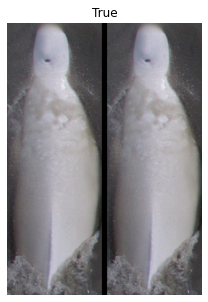

In [51]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

We can also try with a second image that's not from the same class:

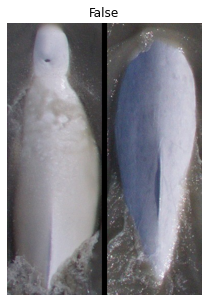

In [52]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

The important thing with transforms that we saw before is that they dispatch over tuples or their subclasses. That's precisely why we chose to subclass `fastuple` in this instance—this way we can apply any transform that works on images to our `SiameseImage` and it will be applied on each image in the tuple:

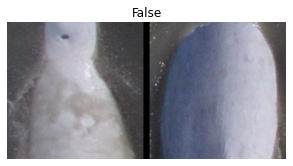

In [53]:
s2 = Resize(224)(s1)
s2.show();

Here the `Resize` transform is applied to each of the two images, but not the Boolean flag. Even if we have a custom type, we can thus benefit from all the data augmentation transforms inside the library.

We are now ready to build the `Transform` that we will use to get our data ready for a Siamese model. First, we will need a function to determine the classes of all our images:

In [54]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

For each image our tranform will, with a probability of 0.5, draw an image from the same class and return a `SiameseImage` with a true label, or draw an image from another class and return a `SiameseImage` with a false label. This is all done in the private `_draw` function. There is one difference between the training and validation sets, which is why the transform needs to be initialized with the splits: on the training set we will make that random pick each time we read an image, whereas on the validation set we make this random pick once and for all at initialization. This way, we get more varied samples during training, but always the same validation set:

In [55]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

We can then create our main transform:

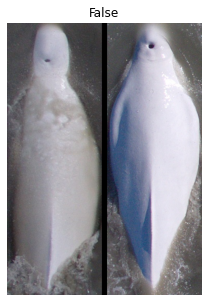

In [56]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In the mid-level API for data collection we have two objects that can help us apply transforms on a set of items, `TfmdLists` and `Datasets`. If you remember what we have just seen, one applies a `Pipeline` of transforms and the other applies several `Pipeline`s of transforms in parallel, to build tuples. Here, our main transform already builds the tuples, so we use `TfmdLists`:

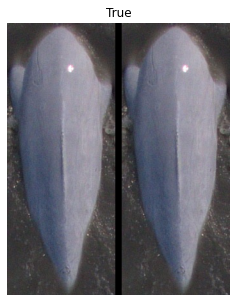

In [57]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 2);

And we can finally get our data in `DataLoaders` by calling the `dataloaders` method. One thing to be careful of here is that this method does not take `item_tfms` and `batch_tfms` like a `DataBlock`. The fastai `DataLoader` has several hooks that are named after events; here what we apply on the items after they are grabbed is called `after_item`, and what we apply on the batch once it's built is called `after_batch`:

In [58]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [60]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

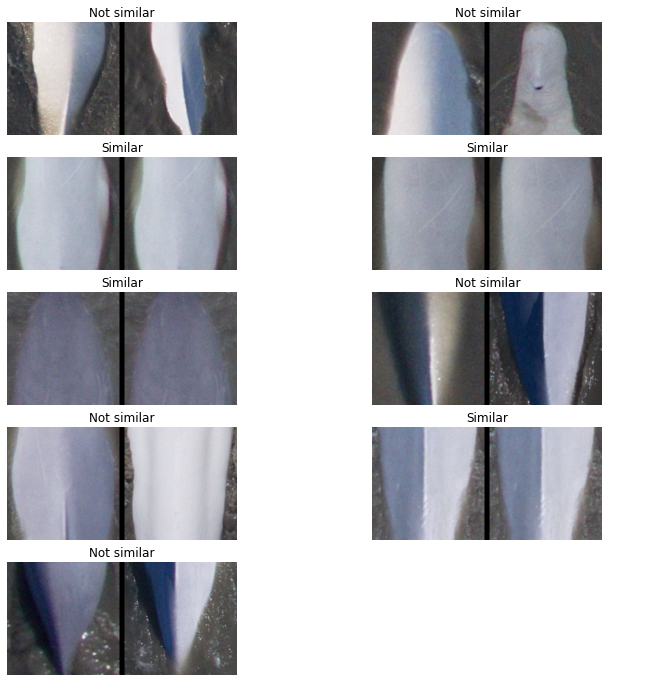

In [61]:
dls.show_batch()

# Training a Siamese Network

For transfer learning, the network needs to be cut. This refers to slicing off the final layer, which is only responsible for ImageNet-specific categorization. In fact, we do not slice off only this layer, but everything from the adaptive average pooling layer onwards. The reason for this will become clear in just a moment. Since different architectures might use different types of pooling layers, or even completely different kinds of heads, we don't just search for the adaptive pooling layer to decide where to cut the pretrained model. Instead, we have a dictionary of information that is used for each model to determine where its body ends, and its head starts. We call this model_meta—here it is for resnet-50:

In [63]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

If we take all of the layers prior to the cut point of -2, we get the part of the model that fastai will keep for transfer learning. Now, we put on our new head. This is created using the function create_head:

In [67]:
create_head(512*2, 2, ps=0.5)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

With this function you can choose how many additional linear layers are added to the end, how much dropout to use after each one, and what kind of pooling to use. By default, fastai will apply both average pooling, and max pooling, and will concatenate the two together (this is the AdaptiveConcatPool2d layer). This is not a particularly common approach, but it was developed independently at fastai and other research labs in recent years, and tends to provide some small improvement over using just average pooling.

fastai is a bit different from most libraries in that by default it adds two linear layers, rather than one, in the CNN head. The reason for this is that transfer learning can still be useful even, as we have seen, when transferring the pretrained model to very different domains. However, just using a single linear layer is unlikely to be enough in these cases; we have found that using two linear layers can allow transfer learning to be used more quickly and easily, in more situations.

Using what we just saw, let's build a custom model for this task and train it. How? We will use a pretrained architecture and pass our two images through it. Then we can concatenate the results and send them to a custom head that will return two predictions. In terms of modules, this looks like this:

In [68]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [75]:
encoder = create_body(resnet34(),cut=-2)
head = create_head(512*2, 2, ps=0.5)

In [76]:
model = SiameseModel(encoder, head)

Before using Learner, we have two more things to define. First, we must define the loss function we want to use. It's regular cross-entropy, but since our targets are Booleans, we need to convert them to integers or PyTorch will throw an error:

In [77]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

More importantly, to take full advantage of transfer learning, we have to define a custom splitter. A splitter is a function that tells the fastai library how to split the model into parameter groups. These are used behind the scenes to train only the head of a model when we do transfer learning.

Here we want two parameter groups: one for the encoder and one for the head. We can thus define the following splitter (params is just a function that returns all parameters of a given module):

In [78]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [79]:
learn = Learner(dls, model, loss_func=loss_func, 
                splitter=siamese_splitter, metrics=accuracy)
learn.freeze()

In [81]:
learn.fit_one_cycle(1, 0.001)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

SuggestedLRs(valley=0.00019054606673307717)

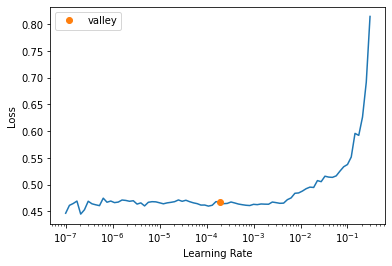

In [39]:
learn.fit_one_cycle(3, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.471459,0.404285,0.831492,01:00
1,0.426483,0.370870,0.834254,00:58
2,0.400778,0.342936,0.852670,00:58


In [40]:
learn.unfreeze()


epoch,train_loss,valid_loss,accuracy,time
0,0.419976,0.350876,0.851750,01:01
1,0.387572,0.330590,0.854512,01:02
2,0.387253,0.315538,0.860958,01:01
3,0.378187,0.316863,0.863720,01:01


In [41]:
learn.fit_one_cycle(10, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.372382,0.325689,0.855433,01:13
1,0.371193,0.338986,0.846225,01:03
2,0.383079,0.327138,0.860958,01:01
3,0.388258,0.308003,0.862799,01:01
4,0.359893,0.291941,0.875691,01:01
5,0.374609,0.292098,0.870166,01:01
6,0.352346,0.293073,0.872007,01:01
7,0.349942,0.274781,0.883057,01:01
8,0.340787,0.299207,0.863720,01:01
9,0.351254,0.287199,0.869245,01:01


Note that we need to pass more transforms than usual—that's because the data block API usually adds them automatically:

- `ToTensor` is the one that converts images to tensors (again, it's applied on every part of the tuple).
- `IntToFloatTensor` converts the tensor of images containing integers from 0 to 255 to a tensor of floats, and divides by 255 to make the values between 0 and 1.

We can now train a model using this `DataLoaders`. It will need a bit more customization than the usual model provided by `vision_learner` since it has to take two images instead of one, but we will see how to create such a model and train it in <<chapter_arch_dtails>>.

## Conclusion

fastai provides a layered API. It takes one line of code to grab the data when it's in one of the usual settings, making it easy for beginners to focus on training a model without spending too much time assembling the data. Then, the high-level data block API gives you more flexibility by allowing you to mix and match some building blocks. Underneath it, the mid-level API gives you greater flexibility to apply any transformations on your items. In your real-world problems, this is probably what you will need to use, and we hope it makes the step of data-munging as easy as possible.

## Questionnaire

1. Why do we say that fastai has a "layered" API? What does it mean?
1. Why does a `Transform` have a `decode` method? What does it do?
1. Why does a `Transform` have a `setup` method? What does it do?
1. How does a `Transform` work when called on a tuple?
1. Which methods do you need to implement when writing your own `Transform`?
1. Write a `Normalize` transform that fully normalizes items (subtract the mean and divide by the standard deviation of the dataset), and that can decode that behavior. Try not to peek!
1. Write a `Transform` that does the numericalization of tokenized texts (it should set its vocab automatically from the dataset seen and have a `decode` method). Look at the source code of fastai if you need help.
1. What is a `Pipeline`?
1. What is a `TfmdLists`? 
1. What is a `Datasets`? How is it different from a `TfmdLists`?
1. Why are `TfmdLists` and `Datasets` named with an "s"?
1. How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. What do you need to do when you want to have your custom items work with methods like `show_batch` or `show_results`?
1. Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

### Further Research

1. Use the mid-level API to prepare the data in `DataLoaders` on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.
1. Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_results` for new type of items. Implement it in your own project.